### Implementing coupled word2vec idea

For this implementation which is specific for the directed graph, we take one node before and one node after a specific node. For example lets assume we have a walk from i to j to k. In our case, this means that i has emmited and j has received a signal. Then j has emitted and k has received a signal. We will try to reconstruct two embeddings, one for emitters and one for receivers and we call them E and R correspondingly. In this implementation, we will give j as input and will try to predict i on one arm of the machine and k on another arm. Then in the loss function we will try to minimize the distance between the emmitor representation of i and receiver representation of j as well as the distance between emmitor representation of j and receivor representation of k.

In [2]:
import torch
import os
import time
import itertools
import torch.nn as nn
from cell import graph_utils, utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph


os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import imp
from cell import  utils, analysis, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [4]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    
    
def build_data_loader(datasets, batch_size, shuffle=True, drop_last=True, num_workers=1):
    data_loader = torch.utils.data.DataLoader(
        ConcatDataset(*[datasets[k][0] for k in datasets.keys()]),
        batch_size=batch_size, 
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers)
    return {k:i for i,k in enumerate(datasets.keys())}, data_loader

In [5]:
class EmitterReceiver_Word2Vec(nn.Module):
    """
    """
    def __init__(self, vocab_size=[93], embedding_size=2, n_arm=1):
        """
        """
        super(EmitterReceiver_Word2Vec, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.n_arm = n_arm
        
        self.embeddings = nn.ModuleList([nn.Embedding(vocab_size[i],
                                                      embedding_size) 
                                         for i in range(n_arm)])
        
        self.linear = nn.ModuleList([nn.Linear(embedding_size,
                                               vocab_size[i]) 
                                     for i in range(n_arm)])
        
#         self.batch_norm = nn.ModuleList([nn.BatchNorm1d(num_features=embedding_size,
#                                                         eps=1e-10, 
#                                                         momentum=0.1, 
#                                                         affine=False) 
#                                          for i in range(n_arm)])
                        

    def encoder(self, context_word, arm):
        h1 = self.embeddings[arm](context_word)
        node_embeddings = [self.embeddings[arm](torch.tensor(i)) for i 
                           in range(self.vocab_size[arm])]
        return node_embeddings, h1

    def decoder(self, context_word_embedding_of_the_other_arm, arm):
        h2 = self.linear[arm](context_word_embedding_of_the_other_arm)
        return h2

    def forward(self, context_word):
        emb = [None] * self.n_arm
        predictions = [None] * self.n_arm
        context_word_embedding = [None] * self.n_arm
        
        for arm in range(self.n_arm):
            node_embeddings, word_embedding  = self.encoder(context_word[arm], arm)
            emb[arm] = node_embeddings
            context_word_embedding[arm] = word_embedding
            
        for arm in range(self.n_arm):
#             which_arm = -1 * arm + 1
            which_arm = arm
            predictions[arm] = self.decoder(context_word_embedding[which_arm], arm)
            
        return emb, predictions

    
def loss_emitter_receiver(prediction, target, n_arm, vocab_size, batch_size):
 
    loss_indep = [None] * n_arm
    
    for arm, (k, v) in enumerate(arm_keys.items()):
        predict[arm] = torch.reshape(prediction[arm], (batch_size, vocab_size))
        loss_indep[arm] = F.cross_entropy(prediction[arm], target[arm])
                
    loss = sum(loss_indep)

    return loss

### Load one walk on the test_all_combined communication network

In [7]:
length = 10000
p = 1
q = 1
N = 1
batch_size = 2000
walk_filename = "walk_node21_32_removed.csv"
roi = "VISp"
project_name = "NPP_GNN_project"
layer_class = "single_layer"
layer = "base_unnormalized_allcombined"
walk_type= "Directed_Weighted_node2vec"

walk_dir = utils.get_walk_dir(roi,
                              project_name, 
                              N, 
                              length, 
                              p, 
                              q, 
                              layer_class, 
                              layer, 
                              walk_type) 


#### Prepare vocab

In [8]:
corpus = utils.read_list_of_lists_from_csv(os.path.join(walk_dir, walk_filename))
vocabulary = prepare_vocab.get_vocabulary(corpus)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=False)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=False)

lenght of vocabulary: 91


In [9]:
corpus[0][0:10]

['0', '71', '34', '10', '5', '35', '17', '59', '27', '14']

In [47]:
len(corpus[0])

10000

#### Create the context-target tuples

In [10]:
receiver_tuples, emitter_tuples = prepare_vocab.emitter_receiver_get_word_context_tuples(corpus)

There are 909818 pairs of receiver target and context words
There are 909909 pairs of emitter target and context words


In [11]:
print(emitter_tuples[0:10])
print(receiver_tuples[0:10])

[('71', '0'), ('34', '71'), ('10', '34'), ('5', '10'), ('35', '5'), ('17', '35'), ('59', '17'), ('27', '59'), ('14', '27'), ('56', '14')]
[('71', '34'), ('34', '10'), ('10', '5'), ('5', '35'), ('35', '17'), ('17', '59'), ('59', '27'), ('27', '14'), ('14', '56'), ('56', '79')]


### Create dataloader

In [12]:
datasets = {}

datasets['E'] = []
emitter_dataset = dataloader.EmitterReceiverDataset(emitter_tuples, word_2_index)
emitter_v_size = prepare_vocab.get_vocab_size_from_list_of_tuples(emitter_tuples)
datasets['E'].append(emitter_dataset)
datasets['E'].append(emitter_v_size)

datasets['R'] = []
receiver_dataset = dataloader.EmitterReceiverDataset(receiver_tuples, word_2_index)
receiver_v_size = prepare_vocab.get_vocab_size_from_list_of_tuples(receiver_tuples)
datasets['R'].append(receiver_dataset)
datasets['R'].append(receiver_v_size)

In [51]:
datasets

{'E': [<cell.Word2vec.dataloader.EmitterReceiverDataset at 0x7fda20f71c50>,
  91],
 'R': [<cell.Word2vec.dataloader.EmitterReceiverDataset at 0x7fda20f71a10>,
  91]}

In [13]:
print(datasets['E'][0].context[0:10], datasets['E'][0].target[0:10])

tensor([90, 17, 68,  9, 15, 32,  3, 27, 43, 46]) tensor([78, 90, 17, 68,  9, 15, 32,  3, 27, 43])


In [53]:
print(datasets['R'][0].context[0:10], datasets['R'][0].target[0:10])

tensor([17, 78, 11, 76, 87, 89,  4, 32, 55, 84]) tensor([78, 11, 76, 87, 89,  4, 32, 55, 84, 56])


In [54]:
[word_2_index[k] for k in [j for (i, j) in emitter_tuples[0:10]]]

[73, 17, 78, 11, 76, 87, 89, 4, 32, 55]

In [55]:
[word_2_index[k] for k in [j for (i, j) in receiver_tuples[0:10]]]

[78, 11, 76, 87, 89, 4, 32, 55, 84, 56]

In [14]:
arm_keys, data_loader = build_data_loader(datasets, batch_size=2000, shuffle=False)

In [16]:
for batch_idx, (data1, data2) in enumerate(data_loader):
    print(data1, data2)
    break

[tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]), tensor([2, 0, 2, 0, 2, 0, 2, 0, 2, 0])] [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


In [16]:
vocab_size = 91
embedding_size = 2
learning_rate = 0.001
n_epochs = 10
n_arm=2

model = EmitterReceiver_Word2Vec(embedding_size=embedding_size, 
                        vocab_size=[v[1] for (k, v) in datasets.items()],
                        n_arm=n_arm).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
training_loss = []


for epoch in range(n_epochs):
    losses = []
    t0 = time.time()
    for batch_idx, all_data in enumerate(data_loader):
        target_data = [data[1].to(device) for data in all_data]
        context_data = [data[0].to(device) for data in all_data]
        context_data = [torch.reshape(context_data[i], (batch_size, 1)) for i in range(len(context_data))]
        optimizer.zero_grad()
        emb, predict = model(context_data)
        loss = loss_emitter_receiver(predict, target_data, n_arm, vocab_size, batch_size)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        
#     t1 = time.time()
#     print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

epoch: 1/10, loss:9.1454
epoch: 2/10, loss:8.9249
epoch: 3/10, loss:8.8548
epoch: 4/10, loss:8.8008
epoch: 5/10, loss:8.7695
epoch: 6/10, loss:8.7568
epoch: 7/10, loss:8.7503
epoch: 8/10, loss:8.7448
epoch: 9/10, loss:8.7392
epoch: 10/10, loss:8.7339


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


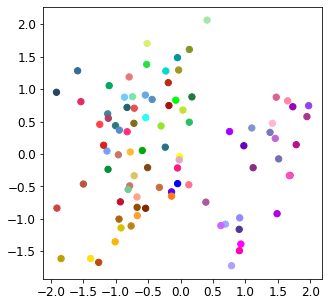

In [17]:
cldf = utils.read_visp_npp_cldf()
vectors = pd.DataFrame(model.embeddings[0].weight.detach().numpy(), index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.columns = ["Z0", "Z1"]
cldf.index = cldf.index.astype(str)
emb = vectors.merge(cldf, on="cluster_id")
fig = plot_utils.plot_embedding(data=emb, plot_dim=2, plot_size=(5,5))

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


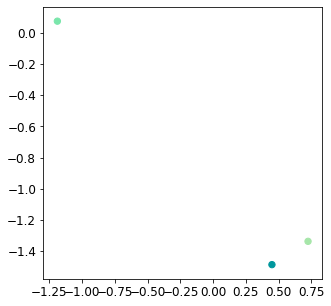

In [112]:
cldf = utils.read_visp_npp_cldf()
vectors = pd.DataFrame(model.embeddings[1].weight.detach().numpy(), index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.columns = ["Z0", "Z1"]
cldf.index = cldf.index.astype(str)
emb = vectors.merge(cldf, on="cluster_id")
fig = plot_utils.plot_embedding(data=emb, plot_dim=2, plot_size=(5,5))

In [33]:
(1,1)[0]

1